In [1]:
import numpy as np
import pandas as pd
import json
import pymongo
from matplotlib import pyplot as plt
from clean_table import clean_individus, clean_simulations, clean_logements, calculate_age, add_id_to_serie
path = '/media/flo/Stockage/Data/MesAides/tables/'

In [2]:
%qtconsole
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


# Import des simulations

In [3]:
t_simulations = clean_simulations(path)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Individus

Les individus ne sont pas uniquement des "demandeurs", ce sont aussi des enfants & conjoints. En fait, ce sont tous les "individus" qui peuvent figurer dans une simulation.

2 Tables : 
- t_individus : la table individus originelle, où 1 ligne = 1 individu (227k lignes)
- t_individus_all : 227k individus

In [4]:
t_individus = clean_individus(path)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (3,5,10,14,15,17,18,19,21,24,27,28,31,33,34,35,36,37,39,41,45,46,48,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Filtre sur 2015

On ne garde que les individus provenant d'une simulations > 01-01-2015

In [5]:
id_demandeurs_2015 = pd.unique(t_simulations._id).tolist()

In [6]:
t_individus = t_individus.loc[t_individus._id_demandeur.isin(id_demandeurs_2015)]

In [7]:
t_individus_full = t_individus.copy()

In [1156]:
t_individus.head(1)

,_id_individu,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,situationsPro,specificSituations,statusMarital,statutMarital,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance,age
0,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,61


### Missing values

In [1469]:
individus_NA = t_individus.isnull().sum().reset_index()
individus_NA.columns = ['features', 'na']
individus_NA.set_index('features', inplace=True)

In [1470]:
individus_NA.head(5)

,na
features,
_id_individu,0
_id_demandeur,0
aCharge,38521
assPreconditionRemplie,185296
autoEntrepreneurActiviteType,72373


In [1471]:
individus_NA['ratio'] = individus_NA['na'] / len(t_individus)

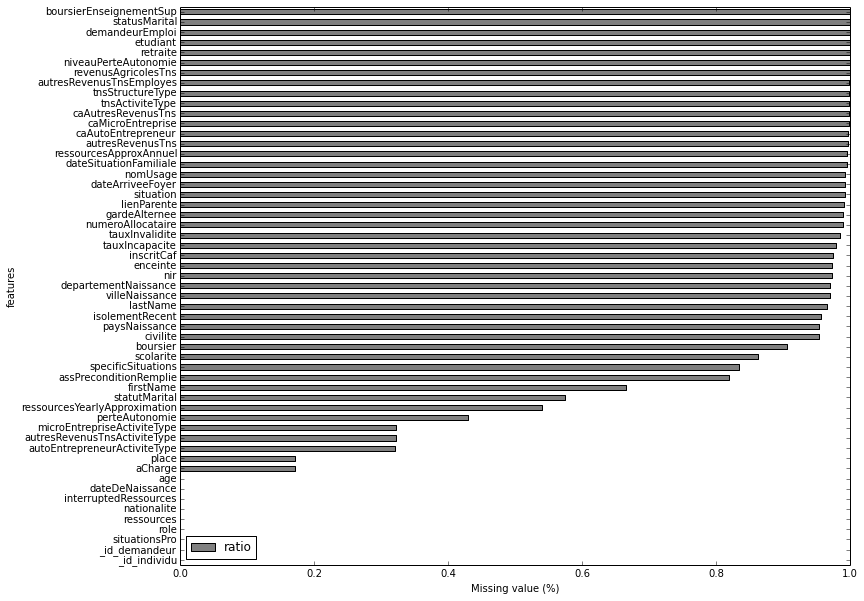

In [1472]:
individus_NA.sort_values('ratio', ascending='False').plot(y= 'ratio', kind='barh', figsize=(12, 10), color='grey')
plt.xlabel('Missing value (%)')

### Enfant

In [1473]:
grouped = t_individus.groupby('_id_demandeur')['role']

In [1474]:
grouped.value_counts().head()

_id_demandeur             role     
54abaf5ed20bc238169b42a0  demandeur    1
54abb15f608e752d1629e1e0  conjoint     1
                          demandeur    1
                          enfant       1
54ac0b9ed20bc238169b4b02  conjoint     1
dtype: int64

In [1475]:
t_role = grouped.value_counts().reset_index()
t_role.columns = ['_id_demandeur', 'role', 'nb']
t_role = t_role[t_role.role != 'demandeur']
t_role.head(3)

,_id_demandeur,role,nb
1,54abb15f608e752d1629e1e0,conjoint,1
3,54abb15f608e752d1629e1e0,enfant,1
4,54ac0b9ed20bc238169b4b02,conjoint,1


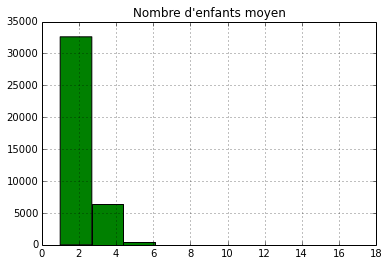

In [1476]:
plt.subplot(111)
t_role[t_role.role == 'enfant']['nb'].hist(color='green')
plt.title('Nombre d\'enfants moyen')

### Situation pro

In [1477]:
t_individus[['_id_individu', '_id_demandeur', 'situationsPro']].loc[200113:200114]

,_id_individu,_id_demandeur,situationsPro
200113,56fd555a91dac855400fd4ab,56fd555a91dac855400fd4a5,"[{'situation': 'demandeur_emploi', '_id': '56f..."
200114,56fd555a91dac855400fd4a9,56fd555a91dac855400fd4a5,"[{'situation': 'autre', '_id': '56fd555a91dac8..."


In [296]:
serie = situation_pro
k = 0
for list_ind in serie:
    if len(list_ind) > 0:
        for d in list_ind:
            d['_id'] = t_individus.iloc[k]._id
    else:
        pass
    k += 1

In [471]:
add_id_to_serie(t_individus, "situationsPro", "_id_individu", "_id_individu")

In [472]:
t_situations_pro = pd.DataFrame(t_individus.situationsPro.sum())

In [473]:
t_situations_pro.head(1)

,_id,_id_individu,situation
0,5422b60b5be58c0200a07549,5422b60b5be58c0200a07548,demandeur_emploi


In [474]:
t_situations_pro.columns = ['_id', '_id_individu', 'situationsPro']
t_situations_pro.head(1)

,_id,_id_individu,situationsPro
0,5422b60b5be58c0200a07549,5422b60b5be58c0200a07548,demandeur_emploi


#### Merge : ajout des situations professionnelles sur la tables t_individus_full

In [8]:
del t_individus_full['situationsPro']
t_individus_full = pd.merge(t_individus_full,
                            t_situations_pro[["_id_individu", "situationsPro"]],
                            on="_id_individu",
                            how="left")
t_individus_full.head(2)

NameError: name 't_situations_pro' is not defined

In [1388]:
t_individus_full.shape

(231810, 55)

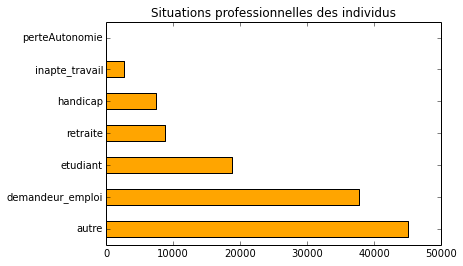

In [1480]:
t_individus_full.situationsPro.value_counts().plot(kind='barh', color='orange')
plt.title('Situations professionnelles des individus')

Remarque : inutile de groupby() car seuls les individus "demandeur" renseignent une "situationsPro" (les autres -> NaN)

### Age

#### Age = 0 

In [1481]:
t_individus[t_individus.age == 0].ix[:, ['dateDeNaissance', 'age', '_id_demandeur']].head(5)

,dateDeNaissance,age,_id_demandeur
3140,2015-08-20,0,54fa2d46e33d9c7979b87724
3933,2015-10-01,0,54fde69b7f2195de05aaf6a2
3934,2015-10-01,0,54fde69b7f2195de05aaf6a2
4494,2015-10-21,0,5501447050a4762d5ab00058
5599,2015-10-10,0,55059f44ba0c71992f3bf5ee


#### Age > 120 

In [1482]:
# Nombre d'individus avec age > 120
t_individus[t_individus.age > 120].age.count()

28

In [1485]:
# Les individus avec age > 120
t_individus[t_individus.age > 120].age.sort_values(ascending=False)

Series([], Name: age, dtype: float64)

#### Filtre sur l'age

In [10]:
# -- On les enlèvve
t_individus = t_individus.loc[(t_individus.age > 0) & (t_individus.age < 120)]
t_individus_full = t_individus_full.loc[(t_individus_full.age > 0) & (t_individus_full.age < 120)]

#### Répartition

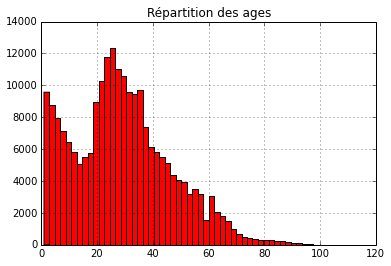

In [1444]:
t_individus.age.hist(color='red', bins=60)
plt.title('Répartition des ages')

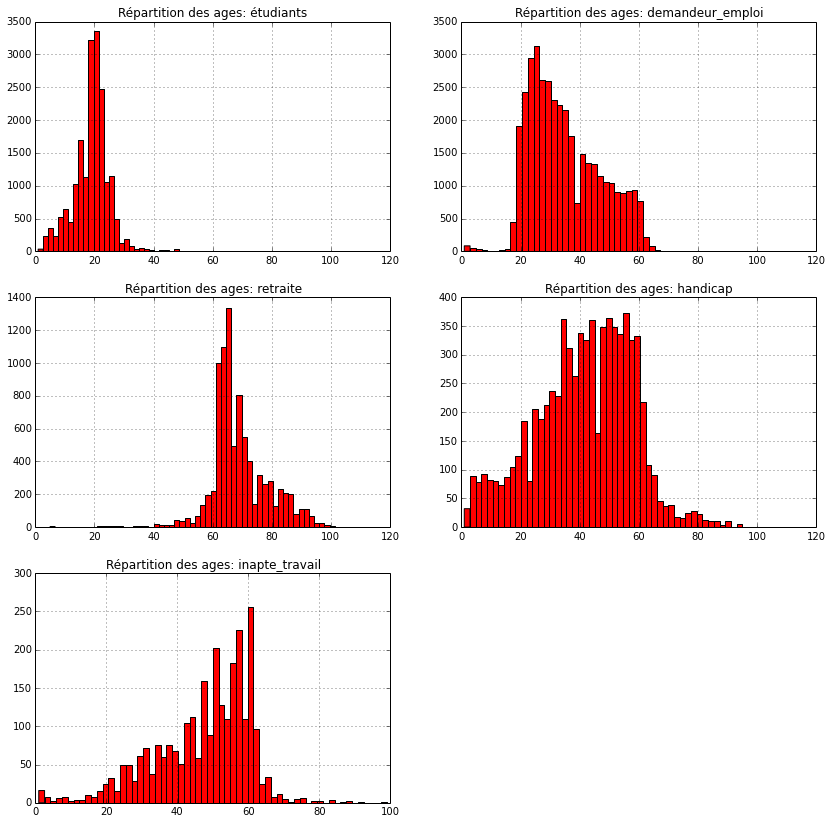

In [1486]:
plt.figure(figsize=(14, 14))
plt.subplot(321)
t_individus_full[t_individus_full.situationsPro == 'etudiant'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: étudiants')
plt.subplot(322)
t_individus_full[t_individus_full.situationsPro == 'demandeur_emploi'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: demandeur_emploi')
plt.subplot(323)
t_individus_full[t_individus_full.situationsPro == 'retraite'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: retraite')
plt.subplot(324)
t_individus_full[t_individus_full.situationsPro == 'handicap'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: handicap')
plt.subplot(325)
t_individus_full[t_individus_full.situationsPro == 'inapte_travail'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: inapte_travail')

De même, il est inutile de filtrer sur les individus uniques (situationsPro..)

(0, 100)

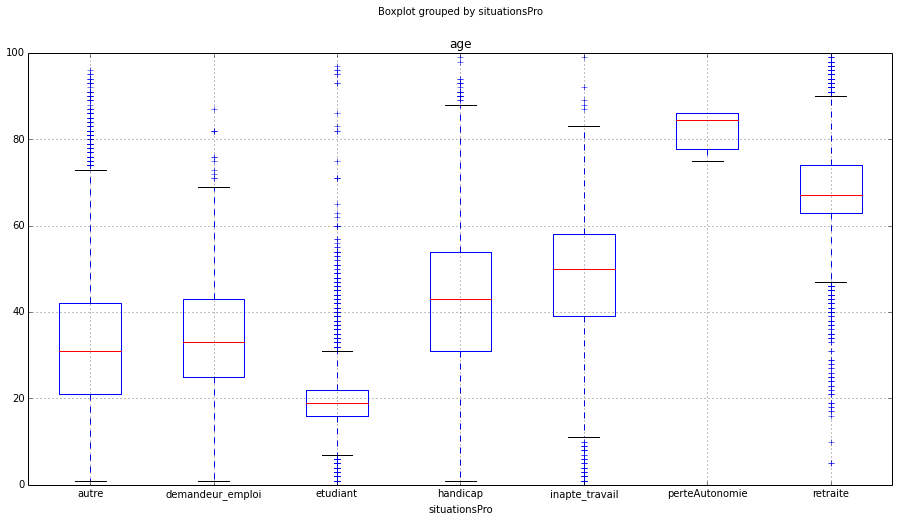

In [1487]:
from matplotlib import gridspec
plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])
# -- On filtre sur les individus ayant moins de 120 ans (enleve les outliers)
t_individus_full[t_individus_full.age < 120].boxplot(column=['age'], by='situationsPro', ax=ax1)
plt.ylim((0, 100))

#### enfant et -10 ans
Validity check

In [1451]:
t_individus.role.value_counts()

demandeur    110048
enfant        66483
conjoint      46582
Name: role, dtype: int64

In [1449]:
t_individus_full.role.value_counts()

demandeur    113952
enfant        66759
conjoint      47204
Name: role, dtype: int64

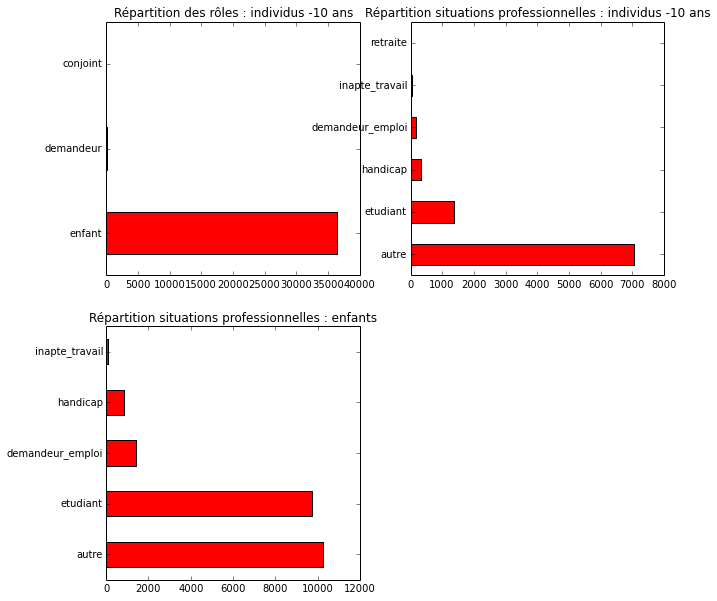

In [1488]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
t_individus_full[t_individus_full.age < 10].role.value_counts().plot(kind='barh', color='red')
plt.title('Répartition des rôles : individus -10 ans')
plt.subplot(222)
t_individus_full[t_individus_full.age < 10].situationsPro.value_counts().plot(kind='barh', color='red')
plt.title('Répartition situations professionnelles : individus -10 ans')
plt.subplot(223)
t_individus_full[t_individus_full.role == 'enfant'].situationsPro.value_counts().plot(kind='barh', color='red')
plt.title('Répartition situations professionnelles : enfants')

### Ressources

In [635]:
t_individus.ressources[0]

"[{'periode': '2014-04', '_id': ObjectId('54465def99337c9d5413681f'), 'montant': 720, 'type': 'revenusSalarie'}, {'periode': '2014-05', '_id': ObjectId('54465def99337c9d5413681e'), 'montant': 720, 'type': 'revenusSalarie'}, {'periode': '2014-06', '_id': ObjectId('54465def99337c9d5413681d'), 'montant': 720, 'type': 'revenusSalarie'}]"

In [632]:
t_individus_test = t_individus.copy()

In [644]:
t_individus_test.ressources =\
    t_individus_test.ressources.apply(
        lambda x: [] if (pd.isnull(x) or x == '[]') else x)

t_individus_test.ressources =\
    [ast.literal_eval(x.replace("ObjectId('", '\'').replace("')", '\''))
        if type(x) == str else x for x in t_individus_test.ressources]

In [645]:
add_id_to_serie(t_individus_test, 'ressources', '_id_individu', '_id_individu')

In [647]:
t_ressources.head()

,_id,_id_individu,montant,periode,type
0,54465def99337c9d5413681f,53cd46e76e5e3202000f4617,720,2014-04,revenusSalarie
1,54465def99337c9d5413681e,53cd46e76e5e3202000f4617,720,2014-05,revenusSalarie
2,54465def99337c9d5413681d,53cd46e76e5e3202000f4617,720,2014-06,revenusSalarie
3,54465def99337c9d54136822,53cd48556e5e3202000f4625,800,2014-04,revenusSalarie
4,54465def99337c9d54136821,53cd48556e5e3202000f4625,800,2014-05,revenusSalarie


In [648]:
t_ressources.to_csv(path + 't_ressources.csv')

#### Merge : ajout des ressources sur la tables t_individus_full

In [9]:
t_ressources = pd.read_csv(path + "t_ressources.csv")
t_ressources.drop('_id', axis=1, inplace=True)
del t_ressources['Unnamed: 0']

In [17]:
t_ressources.head(1)

,_id_individu,montant,periode,type
0,53cd46e76e5e3202000f4617,720,2014-04,revenusSalarie


In [10]:
## -- Merge
t_individus_full = pd.merge(t_individus_full,
                            t_ressources,
                            on="_id_individu",
                            how="left")
t_individus_full.head(2)

,_id_individu,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,statutMarital,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance,age,montant,periode,type
0,54abaf5ed20bc238169b42a1,54abaf5ed20bc238169b42a0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN
1,54abb15f608e752d1629e1e3,54abb15f608e752d1629e1e0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mariage,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN


In [688]:
t_ressources.head()

,_id_individu,montant,periode,type
0,53cd46e76e5e3202000f4617,720,2014-04,revenusSalarie
1,53cd46e76e5e3202000f4617,720,2014-05,revenusSalarie
2,53cd46e76e5e3202000f4617,720,2014-06,revenusSalarie
3,53cd48556e5e3202000f4625,800,2014-04,revenusSalarie
4,53cd48556e5e3202000f4625,800,2014-05,revenusSalarie


# Import des tables

In [11]:
t_patrimoines = pd.read_csv(path + 'patrimoines.csv')

In [12]:
t_logements = clean_logements(path)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (2,6,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [13]:
t_adresses = pd.read_csv(path + 'adresses.csv')

# Clean des tables
### sur 2015

In [14]:
t_individus_full = t_individus_full.rename(columns = {'montant': 'ressources_montant',
                                                     'periode': 'ressources_periode',
                                                     'type': 'ressources_type'})

In [15]:
t_individus_full['ressources_type'] = t_individus_full['ressources_type'].astype(str)
t_individus_full['ressources_type'] = t_individus_full['ressources_type'].replace('nan', np.nan)

### Pourcentages de simulations avec au moins une déclaration commençant par 'rnc_'

25,6 % des simulations contiennent au moins 1 rnc

In [1493]:
t_simulations.head(2)

,Unnamed: 0,__v,_id,_updated,dateDeValeur,email,individus,logement,mobilierValue,patrimoine,phoneNumber,ressourcesYearMoins2Captured,rfr,status,token
0,414,1,54abaf5ed20bc238169b42a0,NaN,2015-01-06 09:48:14.922,NaN,"[{'ressources': [], '_id': ObjectId('54abaf5ed...","{'membreFamilleProprietaire': False, 'adresse'...",NaN,"{'epargneSurLivret': 0, 'valeurLocativeImmoNon...",NaN,False,NaN,test,8bx6BuVVD-WrlM-k_1M7kaa3Ycv339XLJLY6KV7lc2A99h...
1,485,1,54abb15f608e752d1629e1e0,NaN,2015-01-06 09:56:47.892,NaN,"[{'ressources': [], '_id': ObjectId('54abb15f6...","{'membreFamilleProprietaire': False, 'adresse'...",NaN,"{'epargneSurLivret': 0, 'valeurLocativeImmoNon...",NaN,False,NaN,test,pMmisXLdOw1bVc6_5uwZtCeJnllZXr02fgd_kITy38ftvw...


In [16]:
unique_ressources_types = pd.Series(pd.unique(t_individus_full.ressources_type)).dropna()
start_with_rnc = [x for x in unique_ressources_types if (x.startswith('rnc') == True)]

In [17]:
start_with_rnc

['rncRevenusActivite',
 'rncAutresRevenus',
 'rncPensionsRetraitesRentes',
 'rncPensionsAlimentaires',
 'rncPensionsAlimentairesVersees']

In [18]:
demandeurs_au_moins_1rnc = pd.unique(t_individus_full[t_individus_full['ressources_type'].isin(start_with_rnc)]._id_demandeur).tolist()

In [19]:
# -- Simulation avec au moins 1 rnc
t_simulations[t_simulations._id.isin(demandeurs_au_moins_1rnc)].shape  # 28138

(28138, 15)

In [20]:
t_simulations.shape  # 109715

(109715, 15)

In [1530]:
28138/109715

0.25646447614273343

### Répartition des types de ressources par individu
Remarque : attention, un individu peut avori plusieurs type de ressources.

In [1531]:
t_individus_full.ressources_type.value_counts()

revenusSalarie                    1023096
allocationsChomage                 287148
pensionsAlimentairesVersees        191532
pensionsRetraitesRentes            141396
aide_logement                      128628
af                                 109944
pensionsAlimentaires                75564
pensionsInvalidite                  71136
rsa                                 61824
ass                                 55416
aah                                 50220
paje_base                           48324
indJourMaladie                      40284
rncRevenusActivite                  35604
bourseEnseignementSup               33804
revenusStageFormationPro            32076
caAutoEntrepreneur                  31752
stage                               28572
asf                                 21624
indJourMaternite                    20532
clca                                20100
cf                                  20076
rncAutresRevenus                    16245
rncPensionsRetraitesRentes        

In [1541]:
t = t_individus_full.loc[(~t_individus_full.ressources_type.isin(start_with_rnc)) & (t_individus_full.ressources_type.isnull() == False)]

In [1545]:
t_count = t.groupby('_id_individu')['ressources_type'].value_counts().reset_index()
t_count.head(2)

,_id_individu,ressources_type,0
0,54ad0c4f638f222b16b10a8e,revenusSalarie,12
1,54ad4354638f222b16b112b1,revenusSalarie,12


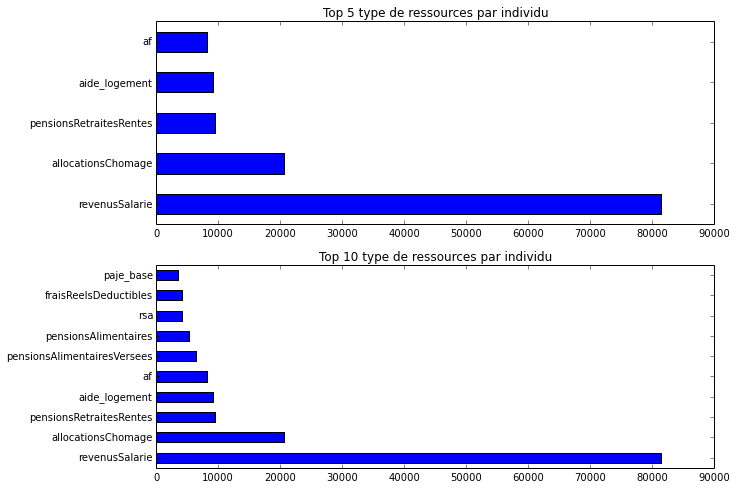

In [1546]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
t_count['ressources_type'].value_counts()[:5].plot(kind='barh')
plt.title('Top 5 type de ressources par individu')
plt.subplot(212)
t_count['ressources_type'].value_counts()[:10].plot(kind='barh')
plt.title('Top 10 type de ressources par individu')


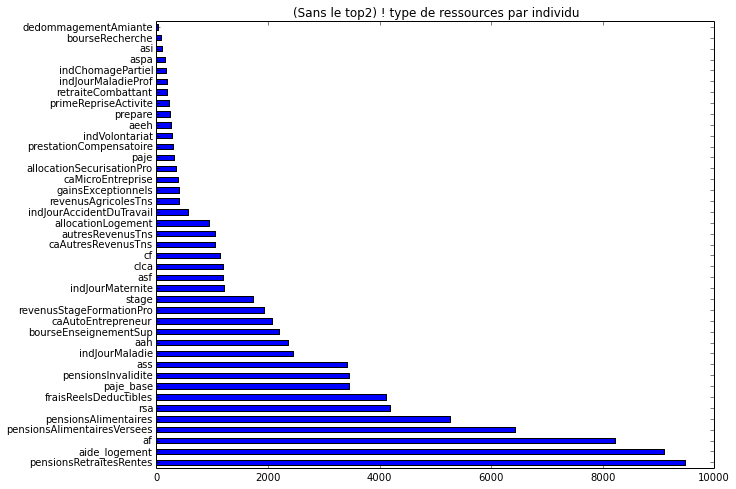

In [1547]:
plt.figure(figsize=(10, 8))
t_count['ressources_type'].value_counts()[2:].plot(kind='barh')
plt.title('(Sans le top2) ! type de ressources par individu')

# Répartition des codes postaux

In [1602]:
t_logements.head(2)

,adresse,adresseConjoint,charges,codePostal,colocation,conjointMemeAdresse,dateArrivee,inhabitantForThreeYearsOutOfLastFive,isChambre,locationType,loyer,membreFamilleProprietaire,participationFrais,pretConventionne,primoAccedant,type,_id_demandeur
0,[{'codePostal': '123'}],NaN,NaN,123,NaN,NaN,NaN,NaN,NaN,NaN,123,True,NaN,NaN,NaN,locataire,53cd46e76e5e3202000f4616
1,[{'codePostal': '97400'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123,NaN,NaN,NaN,False,proprietaire,53cd48556e5e3202000f4624


In [1603]:
t_logements.shape

(110199, 17)

#### Merge adresses

In [21]:
t_adresses.head(1)

,Unnamed: 0,_id_demandeur,adresse,codeInsee,codePostal,nomCommune,ville
0,0,53cd46e76e5e3202000f4616,NaN,NaN,123,NaN,NaN


In [22]:
del t_adresses['Unnamed: 0']

In [23]:
del t_logements['adresse']
del t_logements['codePostal']

In [1609]:
t_adresses.shape

(109970, 6)

In [1610]:
t_logements.shape

(110199, 15)

In [24]:
t_logements = pd.merge(t_adresses, t_logements, on='_id_demandeur', how='right')

In [25]:
t_logements = t_logements.loc[(t_logements.loyer != 123) & (t_logements.codePostal != '12345')]

In [26]:
t_logements.head(4)

,_id_demandeur,adresse,codeInsee,codePostal,nomCommune,ville,adresseConjoint,charges,colocation,conjointMemeAdresse,dateArrivee,inhabitantForThreeYearsOutOfLastFive,isChambre,locationType,loyer,membreFamilleProprietaire,participationFrais,pretConventionne,primoAccedant,type
23,53d66986be4dbe020042bdd5,NaN,NaN,75011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonmeuble,50,False,NaN,NaN,NaN,locataire
27,53d79969f6aa390200a6ccff,NaN,NaN,92500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonmeuble,499,False,NaN,NaN,NaN,locataire
28,53d79a06f6aa390200a6cd09,NaN,NaN,92500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,heberge
29,53d79b10f6aa390200a6cd0d,NaN,NaN,92500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,heberge


In [32]:
%matplotlib inline

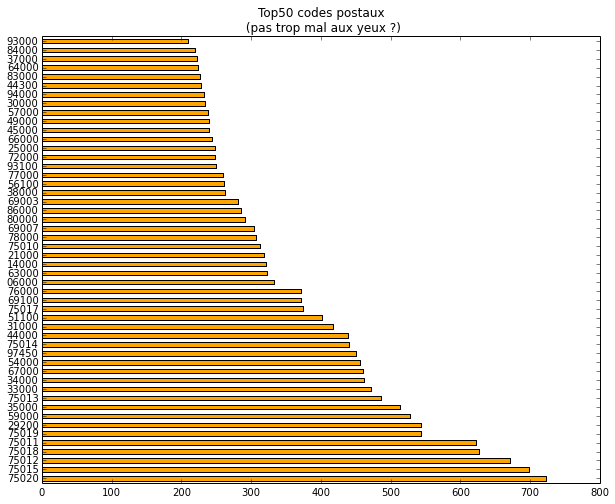

In [27]:
# -- Répartition des codes top50
plt.figure(figsize=(10, 8))
t_logements.codePostal.value_counts()[:50].plot(kind='barh', color='orange')
plt.title('Top50 codes postaux \n (pas trop mal aux yeux ?)')

### Map of postal codes

In [28]:
import folium
import fiona
from shapely.geometry import shape, MultiPolygon, Point

#### Pandas table

In [180]:
t_logements[['codeInsee', 'codePostal']].head()

,codeInsee,codePostal
23,NaN,75011
27,NaN,92500
28,NaN,92500
29,NaN,92500
30,NaN,92500


In [279]:
postal_count = t_logements.codePostal.value_counts().reset_index()
postal_count.columns = ['codePostal', "CP_count"]
postal_count.codePostal = postal_count.codePostal.astype(str)
postal_count.head(2)

,codePostal,CP_count
0,75020,723
1,75015,698


In [280]:
postal_count.shape

(5718, 2)

#### correspondace codePostal -> code INSEE

In [281]:
code_postal_insee = pd.read_csv("/media/flo/Stockage/Data/communes_osm/codepostal_codeinsee_laposte/laposte_hexasmal.csv", sep=";")
code_postal_insee.Code_postal = code_postal_insee.Code_postal.astype(str)

In [282]:
code_postal_insee.drop(['Ligne_5', 'Libelle_acheminement'], axis=1, inplace=True)

In [283]:
code_postal_insee = code_postal_insee.drop_duplicates()

In [284]:
code_postal_insee[code_postal_insee.Code_postal == "1000"]

,Code_commune_INSEE,Nom_commune,Code_postal
315,01053,BOURG EN BRESSE,1000
32669,01344,ST DENIS LES BOURG,1000


### Mapping (à la volée) pour trouver un code INSEE unique par code postal.

-> On prend le premier...

In [285]:
mapping_code_postal = code_postal_insee.groupby('Code_postal')['Code_commune_INSEE'].first().reset_index()

In [286]:
mapping_code_postal.head(2)

,Code_postal,Code_commune_INSEE
0,1000,01053
1,10000,10387


In [287]:
postal_count = pd.merge(postal_count,
                        mapping_code_postal,
                        how='left',
                        left_on='codePostal',
                        right_on='Code_postal')

In [288]:
postal_count.shape

(5718, 4)

In [289]:
postal_count.head(2)

,codePostal,CP_count,Code_postal,Code_commune_INSEE
0,75020,723,75020,75120
1,75015,698,75015,75115


In [290]:
postal_count.drop('Code_postal', axis=1, inplace=True)

In [291]:
postal_count.head(2)

,codePostal,CP_count,Code_commune_INSEE
0,75020,723,75120
1,75015,698,75115


In [292]:
postal_count = postal_count.ix[:, ['Code_commune_INSEE', 'CP_count']]

In [293]:
postal_count = postal_count.groupby('Code_commune_INSEE')['CP_count'].sum().reset_index()

### Get all code_communes table

In [294]:
unique_code_geoJSON = pd.read_csv("/media/flo/Stockage/Data/communes_osm/communes_100m/list_code_insee.txt", names=['Code_commune_INSEE'])

In [302]:
unique_code_geoJSON.head(2)

,Code_commune_INSEE
0,50173
1,06079


In [299]:
postal_count = pd.merge(unique_code_geoJSON, postal_count, on='Code_commune_INSEE', how='left').fillna(0)

In [300]:
postal_count.Code_commune_INSEE.value_counts().value_counts()

1    36701
Name: Code_commune_INSEE, dtype: int64

## Export

In [303]:
postal_count.to_csv(path + 'postal_count.csv')

#### Folium

In [39]:
import json

In [53]:
from branca.colormap import linear

colormap = linear.YlGn.scale(
    postal_count['count'].min(),
    postal_count['count'].max())

print(colormap(5.))

colormap

#feffcb


In [41]:
#map_paris = folium.Map(location=[48.864716, 2.349014])
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

#map_france

In [40]:
geo_json_data = json.load(open('/media/flo/Stockage/Data/communes_osm/communes_100m/communes-20150101-100m.json'))

In [ ]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)
folium.GeoJson(geo_json_data).add_to(map_france)
map_france

In [60]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(geo_str=open('/media/flo/Stockage/Data/communes_osm/communes-20160119-shp/communes-20160119.json').read())

In [70]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/communes-20150101-100m.json').read(),
                      data=postal_count,
                      columns=['Code_commune_INSEE', 'count'],
                      key_on='features.insee',
                      fill_color='YlGn')

map_france

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


AttributeError: 'NoneType' object has no attribute 'get'

In [64]:
postal_count.columns.tolist()

['Code_commune_INSEE', 'count']

In [98]:
map_france.save(path='/media/flo/Stockage/Data/MesAides/map/', outfile='test_map.html')

In [92]:
path

'/media/flo/Stockage/Data/MesAides/tables/'

## Types de logements

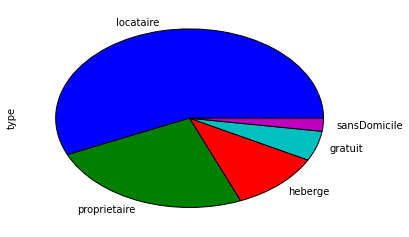

In [37]:
t_logements['type'].value_counts().plot.pie()

In [1595]:
loyers = t_logements.loyer.dropna().astype(int)

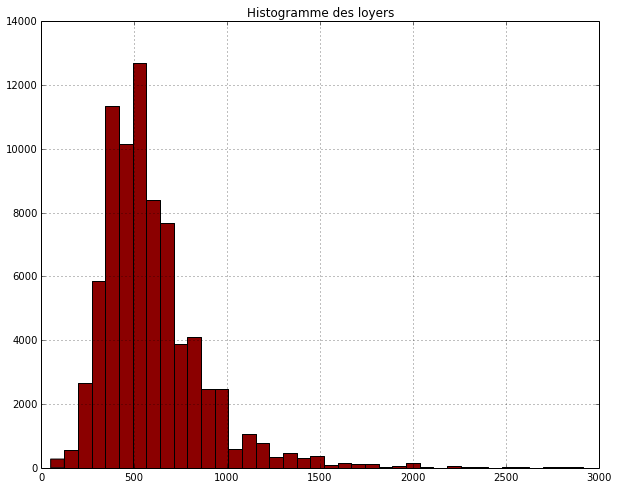

In [1596]:
plt.figure(figsize=(10, 8))
loyers.loc[(loyers > 50) & (loyers < 3000)].hist(bins=40, color='darkred')
plt.title("Histogramme des loyers")

# Ressources négatives

 * __Individu totaux (en comptant les enfants/conjoints)__
 
10.59% des individus contiennent au moins une ressource avec une valeur négative

 * __Individu "demandeur" (role) __
 
15.76% des individus "demandeur" contiennent au moins une ressource avec une valeur négative


In [1179]:
# individu unique
len(pd.unique(t_individus._id_individu).tolist())

222124

In [1177]:
# individu unique ayant au moins une ressource négative
len(pd.unique(t_individus[t_individus.ressources_montant < 0]._id_individu).tolist())

23513

In [1181]:
23513/222124

0.10585528803731249

In [1187]:
# individu "demandeur" unique
len(pd.unique(t_individus[t_individus.role == 'demandeur']._id_individu).tolist())

109561

In [1189]:
len(pd.unique(t_individus[(t_individus.role == 'demandeur') & (t_individus.ressources_montant < 0)]._id_individu).tolist())

17268

In [1190]:
17268/109561

0.15761082867078613

# Date plot

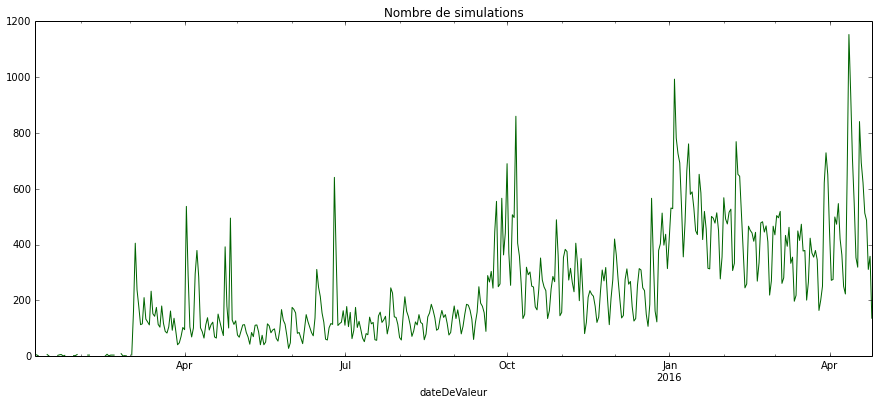

In [1216]:
t_date.resample('1d', how='sum')['temp'].plot(figsize=(15,6), color='darkgreen')
plt.title('Nombre de simulations')

In [1307]:
t_date.index.min()

Timestamp('2015-01-06 09:48:14.922000')

# Type de famille

In [1251]:
%qtconsole

In [1255]:
t_individus.statutMarital.value_counts()

mariage              994431
union_libre          422415
pacs                 170822
relation_libre        62964
celibataire           30493
divorce               11547
separe                 5589
concubinage_rompu      3075
veuf                   2385
pacs_rompu              655
Name: statutMarital, dtype: int64

In [1256]:
statutMarital_valides = t_individus.statutMarital.value_counts().reset_index()['index'].tolist()

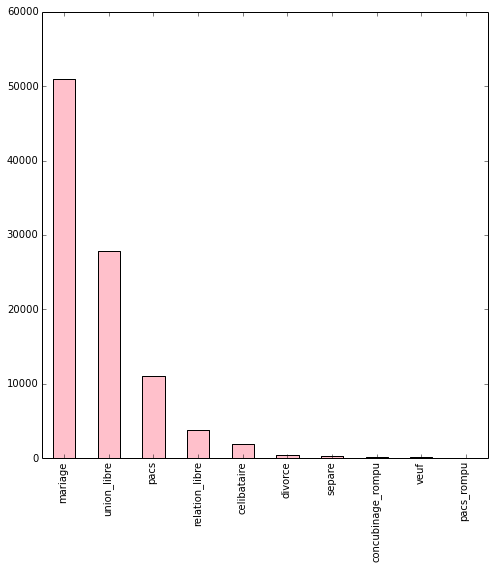

In [1550]:
t_count = t_individus_full[t_individus_full.statutMarital.isin(statutMarital_valides)].groupby('_id_individu')['statutMarital'].value_counts().reset_index()
t_count.statutMarital.value_counts().plot(kind='bar', color='pink', figsize=(8, 8))

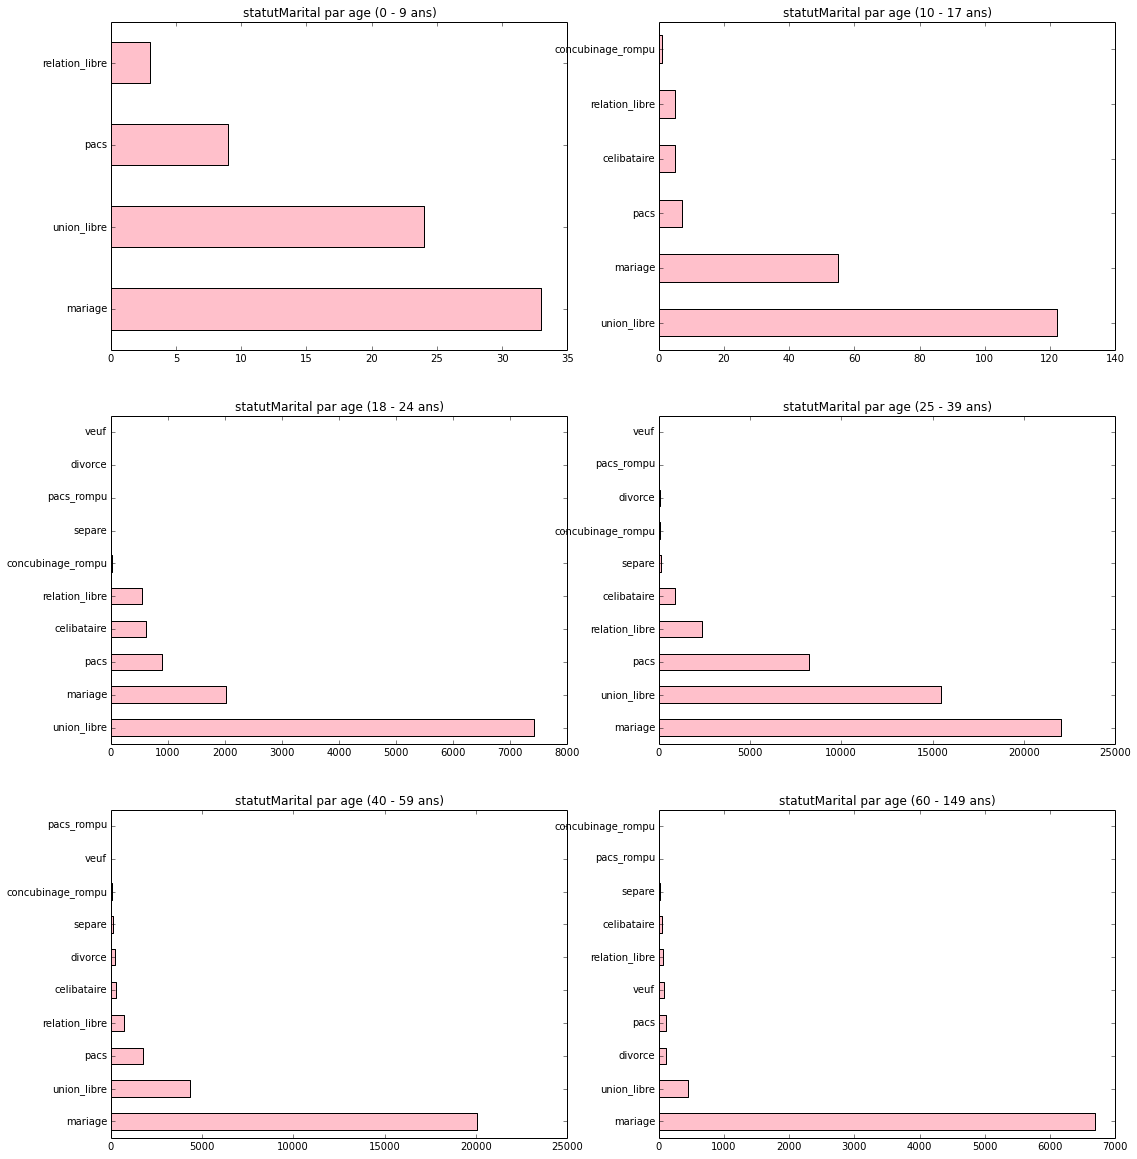

In [1572]:
plt.figure(figsize=(18,20))

#plot_range = range(321, 327)
age_range = [range(0, 10), range(10, 18), range(18, 25), range(25, 40),
             range(40, 60), range(60, 150)]

subplot_count = 321

for age in age_range:
    plt.subplot(subplot_count)
    t_count = t_individus[t_individus.age.isin(age)].groupby('_id_individu')["statutMarital"].value_counts().reset_index()
    t_count.statutMarital.value_counts().plot(kind='barh', color='pink')
    plt.title('statutMarital par age (%i - %i ans)' % (age[0], age[-1]))
    subplot_count += 1

In [1326]:
t_individus[(t_individus.age < 10) & (t_individus.statutMarital == 'mariage')][['dateDeNaissance', 'age', '_id_individu', '_id_demandeur', 'role', 'statutMarital']].head()

,dateDeNaissance,age,_id_individu,_id_demandeur,role,statutMarital
18145,2015-03-04,1,54f7334471bd0dd87b7d99f3,54f7334471bd0dd87b7d99ee,demandeur,mariage
18146,2015-03-04,1,54f7334471bd0dd87b7d99f3,54f7334471bd0dd87b7d99ee,demandeur,mariage
18147,2015-03-04,1,54f7334471bd0dd87b7d99f3,54f7334471bd0dd87b7d99ee,demandeur,mariage
18148,2015-03-04,1,54f7334471bd0dd87b7d99f3,54f7334471bd0dd87b7d99ee,demandeur,mariage
18149,2015-03-04,1,54f7334471bd0dd87b7d99f3,54f7334471bd0dd87b7d99ee,demandeur,mariage


In [1342]:
t_simulations[t_simulations._id == '5566dc09b6b1363e267b933b'].individus.iloc[0]

[{'_id': ObjectId('5566dc09b6b1363e267b934a'),
  'dateDeNaissance': datetime.datetime(2014, 1, 1, 0, 0),
  'interruptedRessources': ['revenusSalarie', 'indJourMaladie'],
  'nationalite': 'fr',
  'ressources': [{'_id': ObjectId('5566dc09b6b1363e267b937a'),
    'montant': 0,
    'periode': '2015-04',
    'type': 'revenusSalarie'},
   {'_id': ObjectId('5566dc09b6b1363e267b9379'),
    'montant': 0,
    'periode': '2015-03',
    'type': 'revenusSalarie'},
   {'_id': ObjectId('5566dc09b6b1363e267b9378'),
    'montant': 1000,
    'periode': '2015-02',
    'type': 'revenusSalarie'},
   {'_id': ObjectId('5566dc09b6b1363e267b9377'),
    'montant': 555.5555555555555,
    'periode': '2015-01',
    'type': 'revenusSalarie'},
   {'_id': ObjectId('5566dc09b6b1363e267b9376'),
    'montant': 555.5555555555555,
    'periode': '2014-12',
    'type': 'revenusSalarie'},
   {'_id': ObjectId('5566dc09b6b1363e267b9375'),
    'montant': 555.5555555555555,
    'periode': '2014-11',
    'type': 'revenusSalarie'}